In [15]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import gsw
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.colors import TwoSlopeNorm
import cmocean as cm
from datetime import datetime

cube = xr.open_dataset(os.path.expanduser('~/Desktop/Summer 2025 Python/calvert_cube.nc'))
ds = xr.open_dataset(os.path.expanduser('~/Desktop/Summer 2025 Python/Hakai_calvert.nc'))
df_stations = ds[['station', 'latitude', 'longitude']].to_dataframe().dropna()
df_stations_unique = df_stations.drop_duplicates(subset=['station', 'latitude', 'longitude'])
station_coords = list(zip(
    df_stations_unique['latitude'],
    df_stations_unique['longitude'],
    df_stations_unique['station']))

def plot_oxygen_timeseries(station_id, ds, ylim=(450, 0), years=[2023, 2024, 2025],
                           show_sill=True, oxymax=200, show_density_contours=True):

    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 20,
        'axes.labelsize': 20,
        'xtick.labelsize': 15,
        'ytick.labelsize': 15,
        'legend.fontsize': 20,
        'figure.titlesize': 20})

    ds_station = ds.where(ds['station'] == station_id, drop=True)
    ds_station = ds_station.dropna(dim='row', subset=['temperature', 'salinity', 'depth', 'time', 'dissolved_oxygen_ml_l'])
    ds_station = ds_station.where(ds_station['time'].dt.year.isin(years), drop=True)

    if ds_station.sizes['row'] < 2:
        print(f"No valid data for station {station_id} in years {years}.")
        return

    pressure = gsw.p_from_z(-ds_station['depth'].values, 51.7)
    sigma_theta = gsw.sigma0(ds_station['salinity'], ds_station['temperature'])
    oxygen_umolkg = ds_station['dissolved_oxygen_ml_l'].values * 44.661

    regular_depth = np.arange(0, 500, 1)
    times = np.unique(ds_station['time'].values)
    oxy_profiles, dens_profiles, valid_times = [], [], []

    for t in times:
        profile = ds_station.where(ds_station['time'] == t, drop=True)
        if profile.sizes['row'] < 2:
            continue
        oxy = np.interp(regular_depth, profile['depth'].values,
                        oxygen_umolkg[ds_station['time'].values == t],
                        left=np.nan, right=np.nan)
        dens = np.interp(regular_depth, profile['depth'].values,
                         sigma_theta.where(ds_station['time'] == t, drop=True).values,
                         left=np.nan, right=np.nan)
        oxy_profiles.append(oxy)
        dens_profiles.append(dens)
        valid_times.append(t)

    if not oxy_profiles:
        print(f"No usable profiles at station {station_id}")
        return

    oxy = np.array(oxy_profiles).T
    density = np.array(dens_profiles).T
    times = np.array(valid_times).astype('datetime64[ns]')
    oxymax = oxymax if oxymax is not None else np.nanmax(oxy)

    fig, ax = plt.subplots(figsize=(1.5 * 1.5 * 6.4, 1.5 * 4.8))
    norm = TwoSlopeNorm(vmin=0, vcenter=60, vmax=oxymax)
    pc = ax.pcolormesh(times, regular_depth, oxy, cmap=cm.cm.balance_r, norm=norm, shading='nearest')

    if show_density_contours:
        contour_settings = [
            (np.linspace(24, 27, 7), 'black', .51),
            ([25.6], 'white', 0.5),
            ([25.7], 'lime', 0.5),
            ([25.8], 'red', 0.5),
            ([25.9], 'blue', 0.5),
            ([26.0], 'black', 0.51),
            ([26.1], 'purple', 0.5),
            ([26.2], 'salmon', 0.5),
            ([26.3], 'yellow', 0.5),
            ([26.4], 'cyan', 0.5)
        ]
        for levels, color, lw in contour_settings:
            cf = ax.contour(times, regular_depth, density, levels=levels, colors=color, linewidths=lw)
            if lw != 0.5:
                ax.clabel(cf, fmt='%1.2f', fontsize=8)
    else:
        # Oxygen contours at intervals of 20 μmol/kg
        base_levels = np.arange(0, np.nanmax(oxy), 20)
        hypoxic_level = 60
        # Black contours (except hypoxic line)
        other_levels = [lvl for lvl in base_levels if not np.isclose(lvl, hypoxic_level)]
        if other_levels:
            cs_other = ax.contour(times, regular_depth, oxy, levels=other_levels, colors='black', linewidths=0.5)
            ax.clabel(cs_other, fmt='%1.0f', fontsize=7)
        # Red contour at 60 μmol/kg
        cs_red = ax.contour(times, regular_depth, oxy, levels=[hypoxic_level], colors='red', linewidths=2)
        ax.clabel(cs_red, fmt='%1.0f', fontsize=8)

    if show_sill:
        ax.plot(times, [130] * len(times), color='black', linestyle='--', linewidth=1.5)
        ax.plot(times, [120] * len(times), color='black', linestyle='--', linewidth=1.5)

    ax.set_title(f"Oxygen Time Series at {station_id}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Depth (m)")
    ax.invert_yaxis()
    ax.set_ylim(ylim)
    fig.colorbar(pc, ax=ax, label="Oxygen (μmol/kg)")
    ax.xaxis.set_major_formatter(DateFormatter('%b %d\n%Y'))

    ax_top = ax.secondary_xaxis('top')
    ax_top.set_xticks(times)
    ax_top.set_xticklabels([pd.Timestamp(t).strftime('%b %-d') for t in times], rotation=90, fontsize=8)
    ax_top.tick_params(axis='x', direction='out', length=3, width=0.5, pad=2)

    plt.tight_layout()

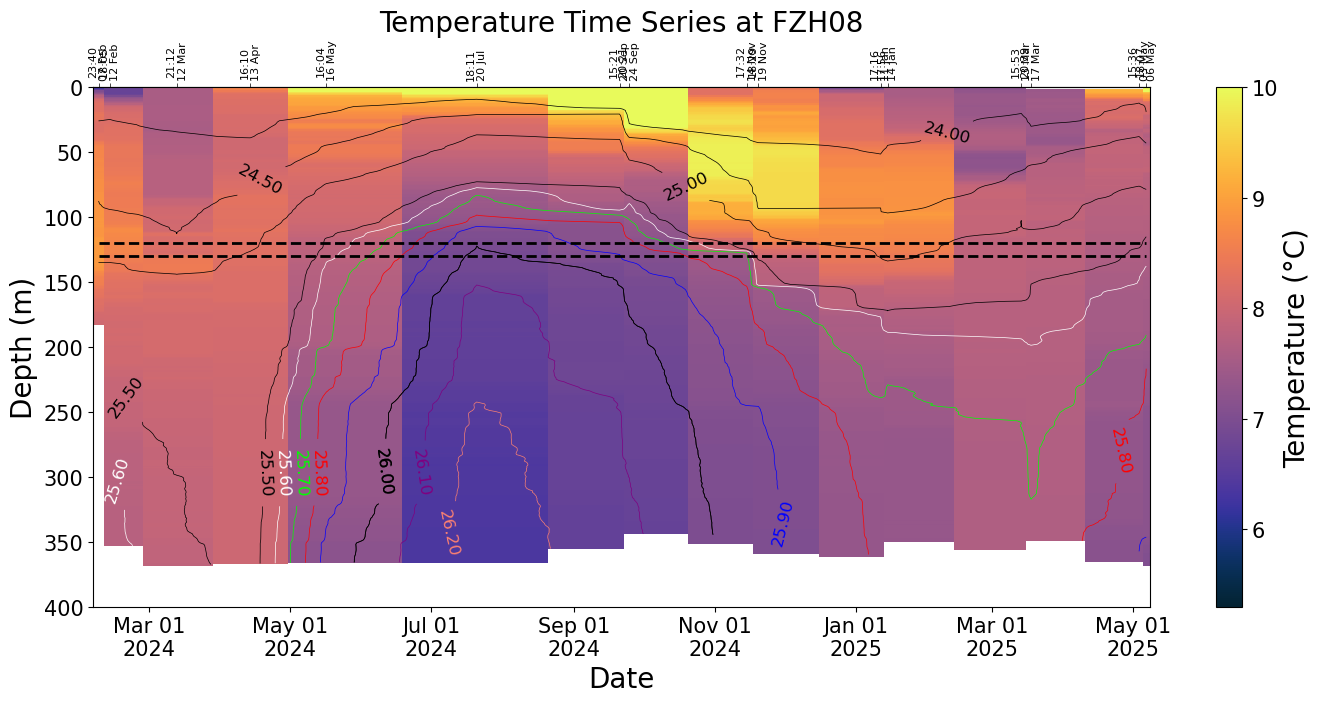

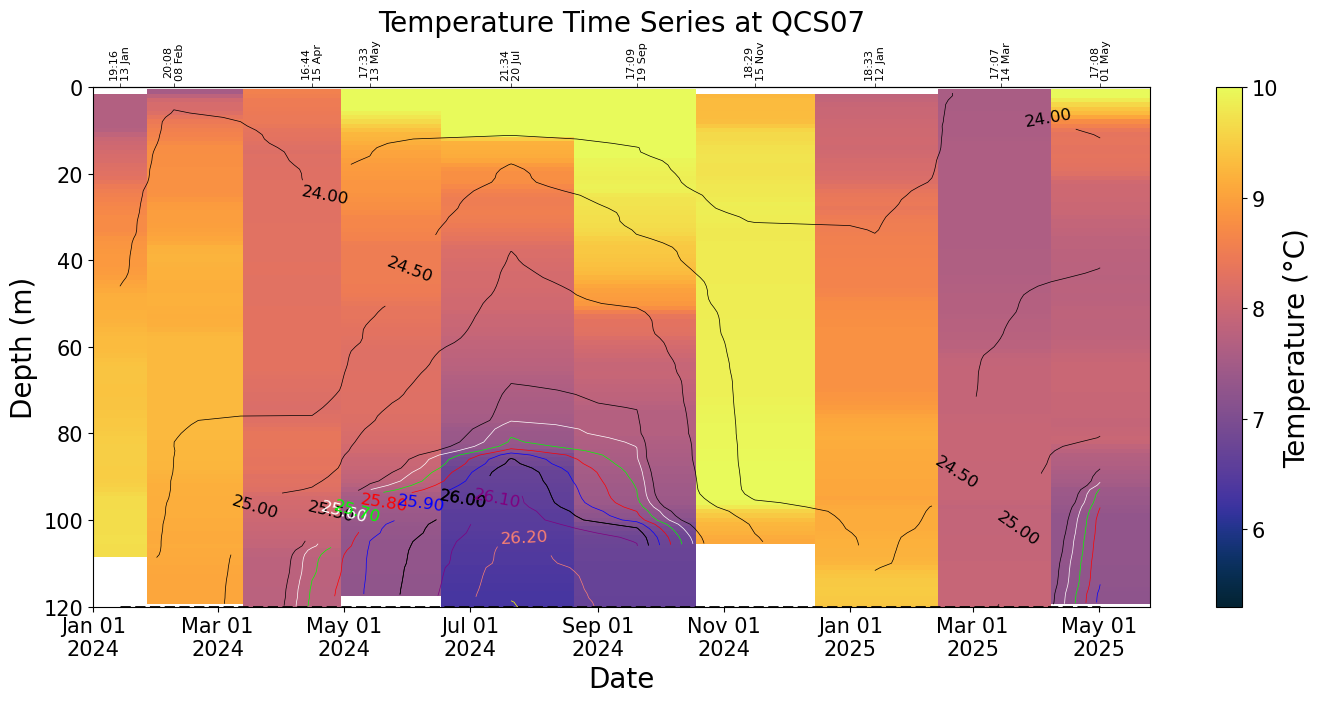

In [9]:
def plot_transect_grid(cube, topo, target_years, ncols=4, xlim=(77, 0), vmin=5.3, vmax=10):
    """
    Plot a grid of temperature sections from a transect cube, filtered by year.

    Parameters:
    - cube: xarray.Dataset with dimensions (transect, depth, along)
    - topo: bathymetry dataset
    - target_years: list of years to include
    - ncols: number of columns in the grid
    - xlim: x-axis limits for each subplot
    """

    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 20,
        'axes.labelsize': 20,
        'xtick.labelsize': 15,
        'ytick.labelsize': 15,
        'legend.fontsize':  20,
        'figure.titlesize': 20})
    
    # ─── Filter transects by year ─────────────────────────────
    transects = cube.transect.values
    selected = [str(t) for t in transects if int(str(t)[:4]) in target_years]
    cube_sel = cube.sel(transect=selected)
    times = [datetime.strptime(t[:8], "%Y%m%d") for t in cube.transect.values]

    n = len(selected)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 1.5 * 6.4, nrows * 1 * 4.8), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, tran_name in enumerate(selected):
        ds = cube_sel.sel(transect=tran_name)

        ax = axes[i]
        temp = ds['temperature'].values
        pdens = ds['potential_density'].values - 1000
        depth = ds['depth'].values
        along = ds['along'].values
        lon = ds['longitude'].values
        lat = ds['latitude'].values

        # Interpolate bathymetry
        interp_bathy = topo['Band1'].interp(
            lon=xr.DataArray(lon, dims='along'),
            lat=xr.DataArray(lat, dims='along'),
            method='nearest')
        ocean_floor = -interp_bathy.values

        # Fill below bathymetry
        ax.fill_between(along / 1000, ocean_floor, 420,
                        where=~np.isnan(ocean_floor), facecolor='grey', zorder=1)

        # Plot temperature
        pc = ax.pcolormesh(along / 1000, depth, temp,
                           shading='auto', cmap=cm.cm.thermal,
                           vmin=vmin, vmax=vmax, zorder=2, )

        # Bathymetry outline
        ax.plot(along / 1000, ocean_floor, color='black', linewidth=1.5)

        # Isopycnals
        for levels, color, lw in [
            (np.linspace(24, 27, 7), 'black', 0.5),
            ([25.6], 'white', 0.5),
            ([25.7], 'lime', 0.5),
            ([25.8], 'red', 0.5),
            ([25.9], 'blue', 0.5),
            ([26.0], 'black', 0.5),
            ([26.1], 'purple', 0.5),
            ([26.2], 'salmon', 0.5),
            ([26.3], 'yellow', 0.5),
            ([26.4], 'cyan', 0.5)]:
            iso = ax.contour(along / 1000, depth, pdens, levels=levels,
                             colors=color, linewidths=lw)
            ax.clabel(iso, fmt='%1.2f', fontsize=6)
        
        date_str = pd.to_datetime(tran_name[:8], format='%Y%m%d').strftime('%B %d')
        leg = 'Out' if 'out' in tran_name else 'Return'
        ax.set_title(f"{date_str} ({leg})", pad=2)
        
                # ─── Top Axis with Time Labels ──────────────────────
        if 'time_top' in ds:
            along_km = along / 1000
            time_top = ds['time_top'].values

            nticks = 8
            idx_ticks = np.linspace(0, len(along_km) - 1, nticks, dtype=int)
            tick_locs = along_km[idx_ticks]
            tick_times = time_top[idx_ticks]

            # Remove NaT or invalids
            valid_mask = ~pd.isnull(tick_times)
            tick_locs = tick_locs[valid_mask]
            tick_times = tick_times[valid_mask]
            tick_labels = [pd.to_datetime(t).strftime('%b %d %H:%M') for t in tick_times]

            ax_top = ax.secondary_xaxis('top')
            ax_top.set_xticks(tick_locs)
            ax_top.set_xticklabels(tick_labels, rotation=30, ha='center', fontsize=8)

            # Add minor ticks
            from matplotlib.ticker import AutoMinorLocator
            ax_top.xaxis.set_minor_locator(AutoMinorLocator(n=2))
            ax_top.tick_params(which='minor', length=3, width=0.8)

    ax.invert_yaxis()
    ax.invert_xaxis()
    ax.set_xlim(xlim)
    
    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout before placing colorbar and labels
    plt.tight_layout(rect=[0.03, 0.04, 0.85, 0.94])  # tighter left/right again

    cbar_ax = fig.add_axes([0.87, 0.25, 0.015, 0.5])  # move colorbar left again
    cbar = fig.colorbar(pc, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label("Temperature (°C)", fontsize=30)

    fig.suptitle(f"Temperature Sections ({', '.join(map(str, target_years))})", fontsize=40)
    # Adjusted subplot region: match rect used in tight_layout
    left, right = 0.03, 0.85  # These should match your tight_layout(..., rect=[...])
    x_center = (left + right) / 2

    fig.text(x_center, 0.01, 'Distance along transect (km)', ha='center', va='center', fontsize=30)
    fig.text(0.012, 0.5, 'Depth (m)', ha='center', va='center', rotation='vertical', fontsize=30)

topo = xr.open_dataset(os.path.expanduser('~/Desktop/Summer 2025 Python/british_columbia_3_msl_2013.nc'))

def plot_station_timeseries(station_id, ds, ylim=(500, 0), years=[2023, 2024, 2025]):
    import matplotlib.pyplot as plt
    from matplotlib.dates import DateFormatter
    import numpy as np
    import cmocean as cm
    import gsw
    import pandas as pd

    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 20,
        'axes.labelsize': 20,
        'xtick.labelsize': 15,
        'ytick.labelsize': 15,
        'legend.fontsize': 20,
        'figure.titlesize': 20})

    # Filter to the desired station
    ds_station = ds.where(ds['station'] == station_id, drop=True)

    # Drop rows missing required variables
    ds_station = ds_station.dropna(dim='row', subset=['temperature', 'salinity', 'depth', 'time'])

    # Filter by year
    ds_station = ds_station.where(ds_station['time'].dt.year.isin(years), drop=True)

    if ds_station.sizes['row'] < 2:
        print(f"No valid data for station {station_id} in years {years}.")
        return

    # Group by time
    grouped = ds_station.groupby('time')

    # Prepare interpolation grid
    regular_depth = np.arange(0, 500, 1)

    temp_profiles = []
    dens_profiles = []
    valid_times = []

    for t, group in grouped:
        if group.sizes['row'] < 2:
            continue
        depth_vals = group['depth'].values
        temp_vals = group['temperature'].values
        sal_vals = group['salinity'].values

        # Compute sigma_theta on-the-fly for this profile
        dens_vals = gsw.sigma0(sal_vals, temp_vals)

        # Interpolate
        temp_interp = np.interp(regular_depth, depth_vals, temp_vals, left=np.nan, right=np.nan)
        dens_interp = np.interp(regular_depth, depth_vals, dens_vals, left=np.nan, right=np.nan)

        temp_profiles.append(temp_interp)
        dens_profiles.append(dens_interp)
        valid_times.append(t)

    if not temp_profiles:
        print(f"No usable profiles at station {station_id}")
        return

    temp = np.array(temp_profiles).T
    density = np.array(dens_profiles).T
    times = np.array(valid_times).astype('datetime64[ns]')

    # Plotting
    fig, ax = plt.subplots(figsize=(1.5 * 1.5 * 6.4, 1.5 * 4.8))
    pc = ax.pcolormesh(times, regular_depth, temp, cmap=cm.cm.thermal, shading='nearest', vmin=5.3, vmax=10)

    for levels, color, lw in [
            (np.linspace(24, 27, 7), 'black', .51),
                        ([25.6], 'white', 0.5),
                        ([25.7], 'lime', 0.5),
                        ([25.8], 'red', 0.5),
                        ([25.9], 'blue', 0.5),
                        ([26.0], 'black', 0.51),
                        ([26.1], 'purple', 0.5),
                        ([26.2], 'salmon', 0.5),
                        ([26.3], 'yellow', 0.5),
                        ([26.4], 'cyan', 0.5)]:
        cf_iso = ax.contour(times, regular_depth, density, levels=levels, colors=color, linewidths=lw)
        if lw != 0.3:
            ax.clabel(cf_iso, fmt='%1.2f')

    ax.plot(times, [130] * len(times), color='black', linewidth=2, linestyle='--')
    ax.plot(times, [120] * len(times), color='black', linewidth=2, linestyle='--')

    ax.set_title(f"Temperature Time Series at {station_id}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Depth (m)")
    ax.invert_yaxis()
    ax.set_ylim(ylim)
    fig.colorbar(pc, ax=ax, label="Temperature (°C)")
    ax.xaxis.set_major_formatter(DateFormatter('%b %d\n%Y'))

    ax_top = ax.secondary_xaxis('top')
    ax_top.set_xticks(times)
    ax_top.set_xticklabels([pd.Timestamp(t).strftime('%H:%M\n%d %b') for t in times], rotation=90, fontsize=8)
    ax_top.tick_params(axis='x', direction='out', length=3, width=0.5, pad=2)

    plt.tight_layout()

plot_station_timeseries("FZH08", ds, years = [2024, 2025], ylim = (400, 0))
plot_station_timeseries("QCS07", ds, years = [2024, 2025], ylim = (120, 0))

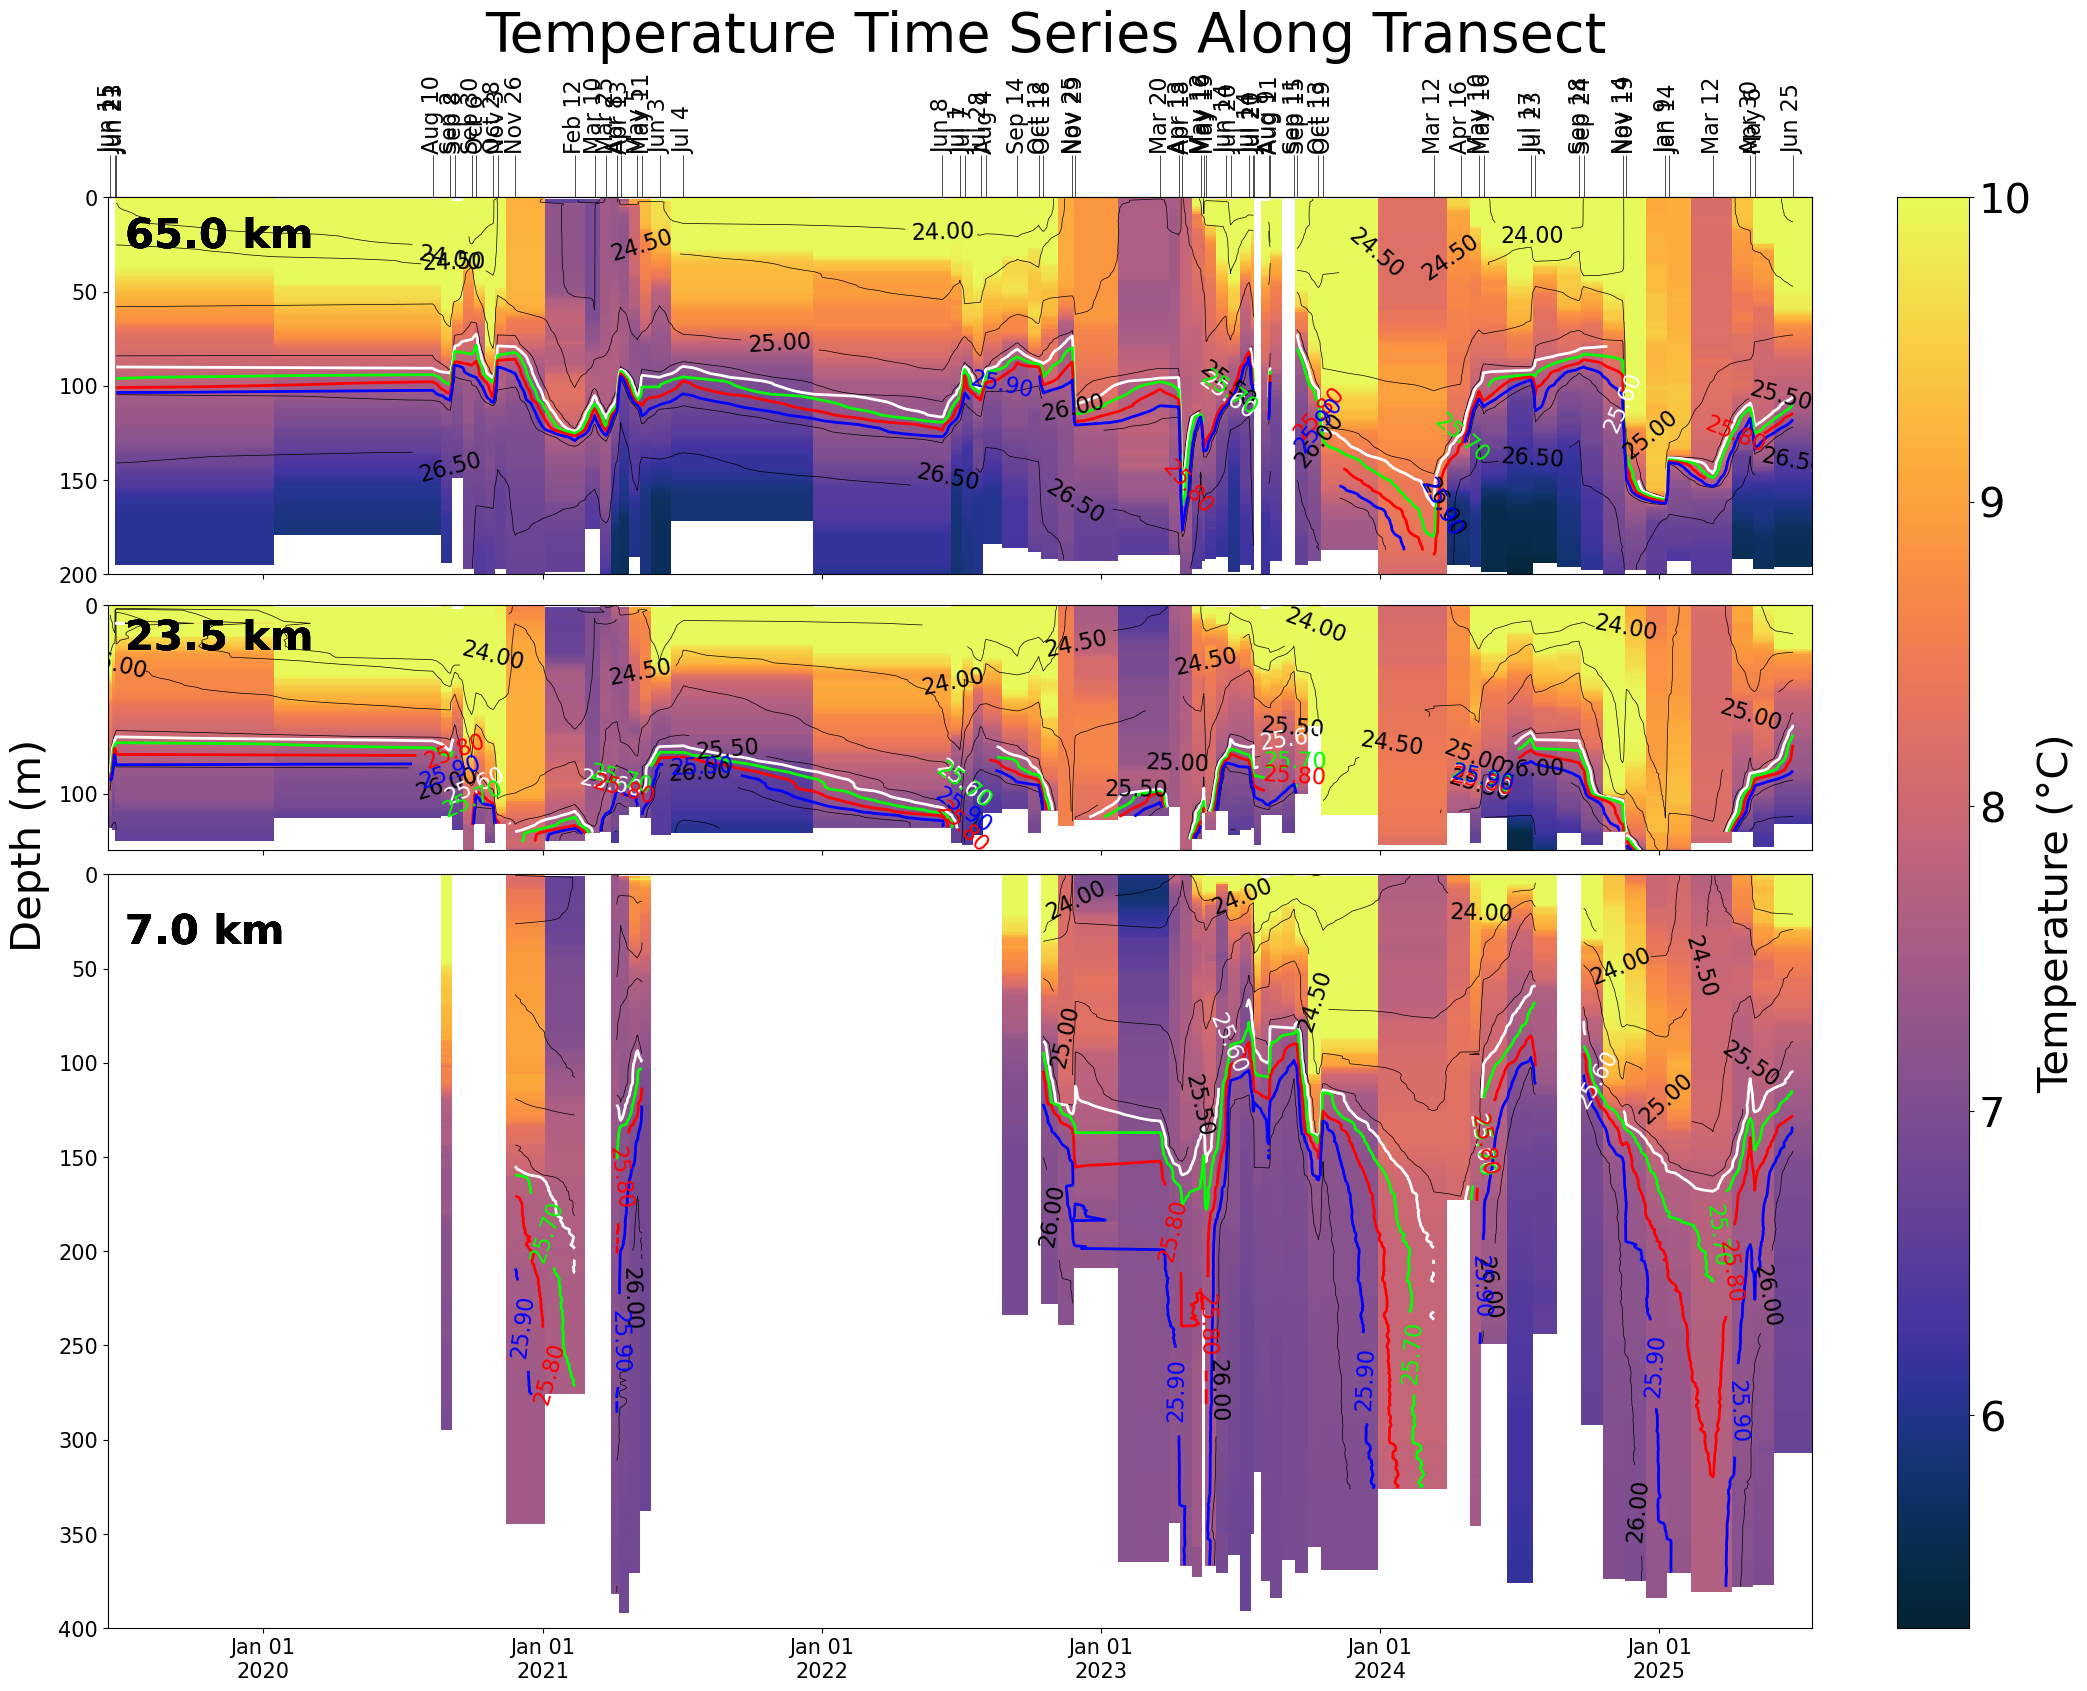

In [16]:
def plot_temp_time_series_subplots(
    cube,
    along_values,
    target_years=[2019, 2020, 2021, 2022, 2023, 2024, 2025],
    ylims=[(400,0), (130,0), (200,0)], start_month=None):
    """
    Plot vertically stacked subplots of temperature time series
    for multiple along positions, with subplot heights proportional
    to their max depth.
    """
    import matplotlib.pyplot as plt
    from matplotlib.dates import DateFormatter
    import pandas as pd
    import numpy as np

    # Calculate the height ratios based on ylims
    max_depths = [yl[0] for yl in ylims]
    max_depth = max(max_depths)
    height_ratios = [d / max_depth for d in max_depths]

    n = len(along_values)
    fig, axes = plt.subplots(nrows=n, figsize=(1.3 * 16, 1.2*  14), constrained_layout=True, gridspec_kw={'height_ratios': height_ratios})

    fig.suptitle("Temperature Time Series Along Transect",fontsize=40)

    if n==1:
        axes = [axes]
    # Collect all times after filtering for years and start month
    all_times = []

    for along_value in along_values:
        cube_sel = cube.sel(along=along_value)
        times_this = [datetime.strptime(t[:8], "%Y%m%d") for t in cube_sel.transect.values]
        # Filter by year and optional month
        filtered_times = [
            t for t in times_this
            if t.year in target_years and (start_month is None or t >= datetime(target_years[0], start_month, 1))
        ]
        all_times.extend(filtered_times)

    # Unique sorted time axis
    unique_times = sorted({t for t in all_times})

    for ax, along_value, ylim in zip(axes, along_values, ylims):
        # Subset cube
        cube_sel = cube.sel(along=along_value)

        temp = cube_sel['temperature'].values
        density = cube_sel['potential_density'].values - 1000
        depth = cube_sel['depth'].values
        times = [datetime.strptime(t[:8], "%Y%m%d") for t in cube_sel.transect.values]

        filtered = [
            (t, te, de)
            for t, te, de in zip(times, temp, density)
            if (
                t.year in target_years
                and (start_month is None or t >= datetime(target_years[0], start_month, 1))
                and not np.all(np.isnan(te))
            )
        ]

        if not filtered:
            print(f"No data for along={along_value}")
            continue

                # Extract times and data
        times_data, temp_data, density_data = zip(*sorted(filtered))

        # Create arrays with NaNs for all times
        temp_grid = np.full((temp_data[0].shape[0], len(unique_times)), np.nan)
        density_grid = np.full_like(temp_grid, np.nan)

        # Fill where times match
        for i, t in enumerate(times_data):
            time_idx = unique_times.index(t)
            temp_grid[:, time_idx] = temp_data[i]
            density_grid[:, time_idx] = density_data[i]
        temp = np.array(temp)
        density = np.array(density)

        pc = ax.pcolormesh(unique_times, depth, temp_grid,
                        cmap=cm.cm.thermal, shading='nearest',
                        vmin=5.3, vmax=10)

        # And contours
        for levels, color, lw in [
            (np.linspace(24, 27, 7), 'black', 0.5),
            # (np.linspace(26, 27, 11), 'black', 0.5),
            ([25.6], 'white', 2),
            ([25.7], 'lime', 2),
            ([25.8], 'red', 2),
            ([25.9], 'blue', 2)]:
            cf_iso = ax.contour(unique_times, depth, density_grid, levels=levels,
                                colors=color, linewidths=lw, linestyles='-')
            if lw !=0.3:
                ax.clabel(cf_iso, fmt='%1.2f', fontsize = 16)
            ax.text(
                0.01, 0.95,
                f"{along_value/1000:.1f} km",
                transform=ax.transAxes,
                fontsize=30,
                fontweight="bold",
                va="top",
                ha="left")
        # ax.plot(unique_times, [130]*len(unique_times), color='black', linewidth=2)
        ax.invert_yaxis()
        ax.set_ylim(ylim)

        ax.xaxis.set_major_formatter(DateFormatter('%b %d\n%Y'))
        if ax is axes[-1]:
            ax.set_xlabel("")
        else:
            ax.set_xticklabels([])

        if ax is axes[0]:
            ax_top = ax.secondary_xaxis('top')
            ax_top.set_xticks(unique_times)
            ax_top.set_xticklabels([pd.Timestamp(t).strftime('%b %-d') for t in unique_times], rotation=90, fontsize = 16)
            ax_top.tick_params(axis='x', direction='out', length=3, width=0.5, pad=2, size = 30)

    plt.rcParams.update({
        "xtick.labelsize": 30,      # X tick labels
        "ytick.labelsize": 30,      # Y tick labels
        "axes.titlesize": 30,
        "axes.labelsize": 30,
        "figure.titlesize": 40})
    fig.colorbar(pc, ax=axes, label="Temperature (°C)", orientation='vertical')
    fig.supylabel("Depth (m)", fontsize=30)

plot_temp_time_series_subplots(
    cube,
    along_values=[65000, 23500, 7000],
    ylims=[(200,0), (130,0), (400,0)],
    target_years=[2019, 2020, 2021, 2022, 2023, 2024,2025], start_month = 1)